### Load the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
sns.set()
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import StackingClassifier


### Load the dataset

Let's load the dataset and have a look around

In [2]:
df=pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')

In [3]:
df.shape

(768, 9)

In [4]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [5]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


At first glance everything looks quite good. There are no missing values. All the features are continous numeric features. 
We will come back to examine in detail.

### Create a baseline model

Here we create a simple logistic regression model as the baseline model. We have not done any preprocessing. We just want to create a benchmark against which we will measure the performance of our subsequent models

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X_base=df.drop('Outcome',axis=1)
y_base=df['Outcome']

X_base.shape,y_base.shape

X_train_base, X_test_base, y_train_base, y_test_base=train_test_split(X_base,y_base,test_size=0.2)

## Logistic Regression Model

from sklearn.linear_model import LogisticRegression

lr=LogisticRegression(random_state=0)

lr.fit(X_train_base,y_train_base)

from sklearn.metrics import accuracy_score

y_pred_base=lr.predict(X_test_base)

print(accuracy_score(y_test_base,y_pred_base))
print(classification_report(y_test_base,y_pred_base))

0.7597402597402597
              precision    recall  f1-score   support

           0       0.77      0.88      0.82        98
           1       0.72      0.55      0.63        56

    accuracy                           0.76       154
   macro avg       0.75      0.72      0.72       154
weighted avg       0.76      0.76      0.75       154



### Exploratory Data Analysis

For this dataset, the violin plot helps us understand how the distribution of various features differs between individuals with and without diabetes. It allows us to observe any patterns or differences in the distributions of features such as Glucose, Blood Pressure, Skin Thickness, Insulin, BMI, Diabetes Pedigree Function, and Age, based on the outcome of diabetes.

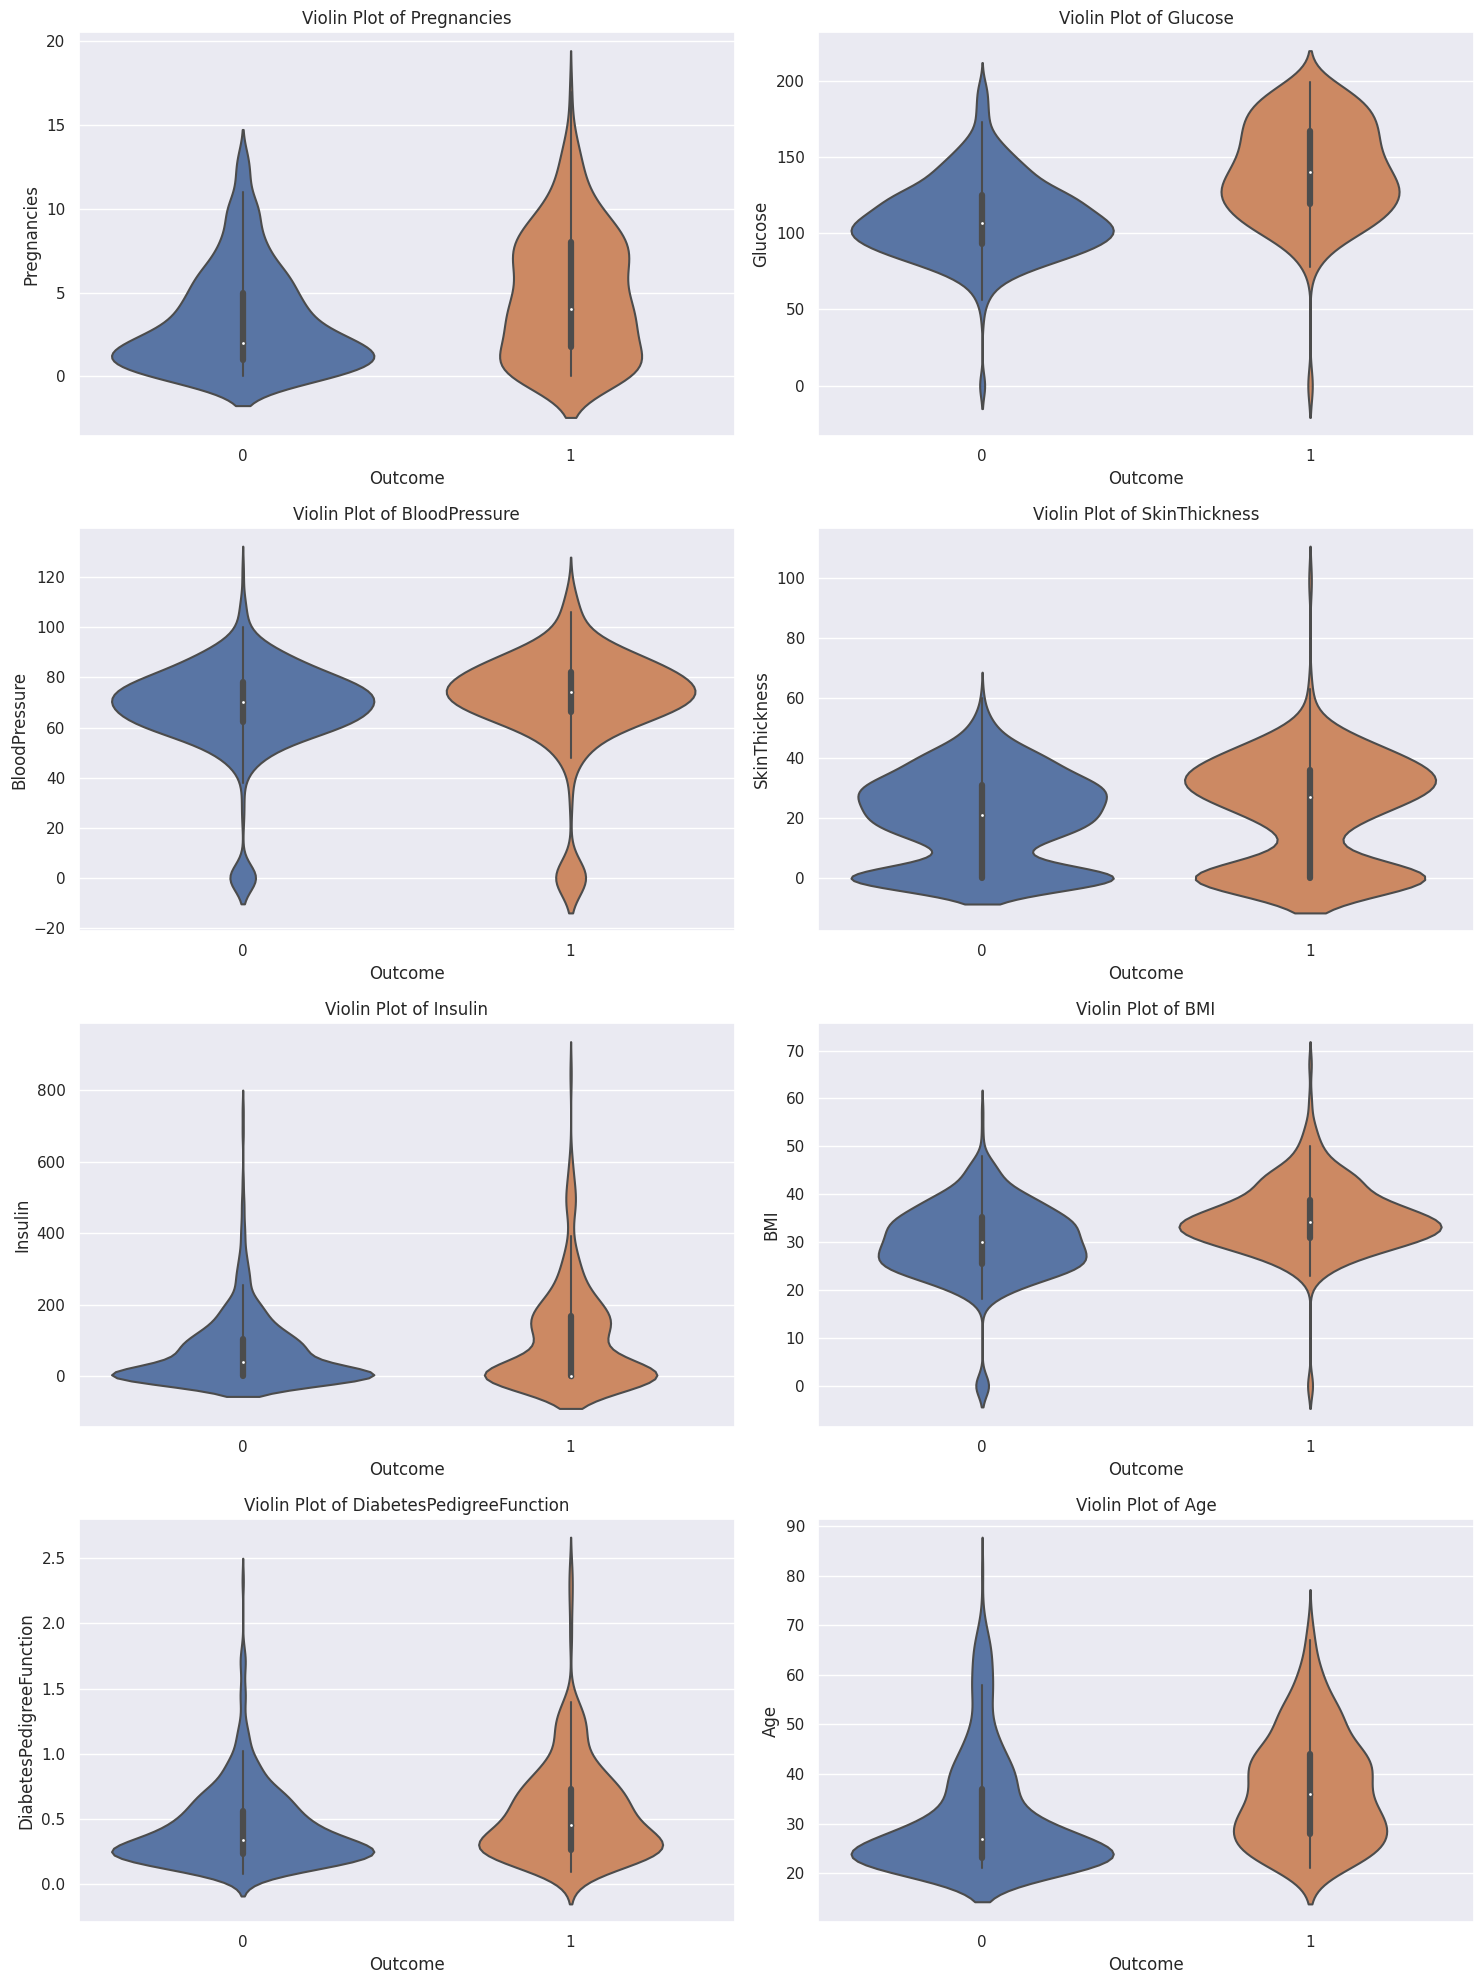

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

# Specify the columns you want to plot
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot violin plots for each column
for i, column in enumerate(columns):
    sns.violinplot(x='Outcome', y=column, data=df, ax=axs[i])
    axs[i].set_title(f'Violin Plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()


### Something's wrong
We see many zero values in columns which should always have non zero values. Features like Glucose are always greater than zero for a person who is alive. It appears zero values have been entered when the data was not available. So we replace zeros in those columns with NaN

In [9]:
weird_column=['Glucose','BloodPressure','SkinThickness','Insulin','BMI']

### Replacing zeros with NaN in unusual columns

In [10]:
df[weird_column]=df[weird_column].replace(0,np.NaN)

In [11]:
df.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

<Axes: >

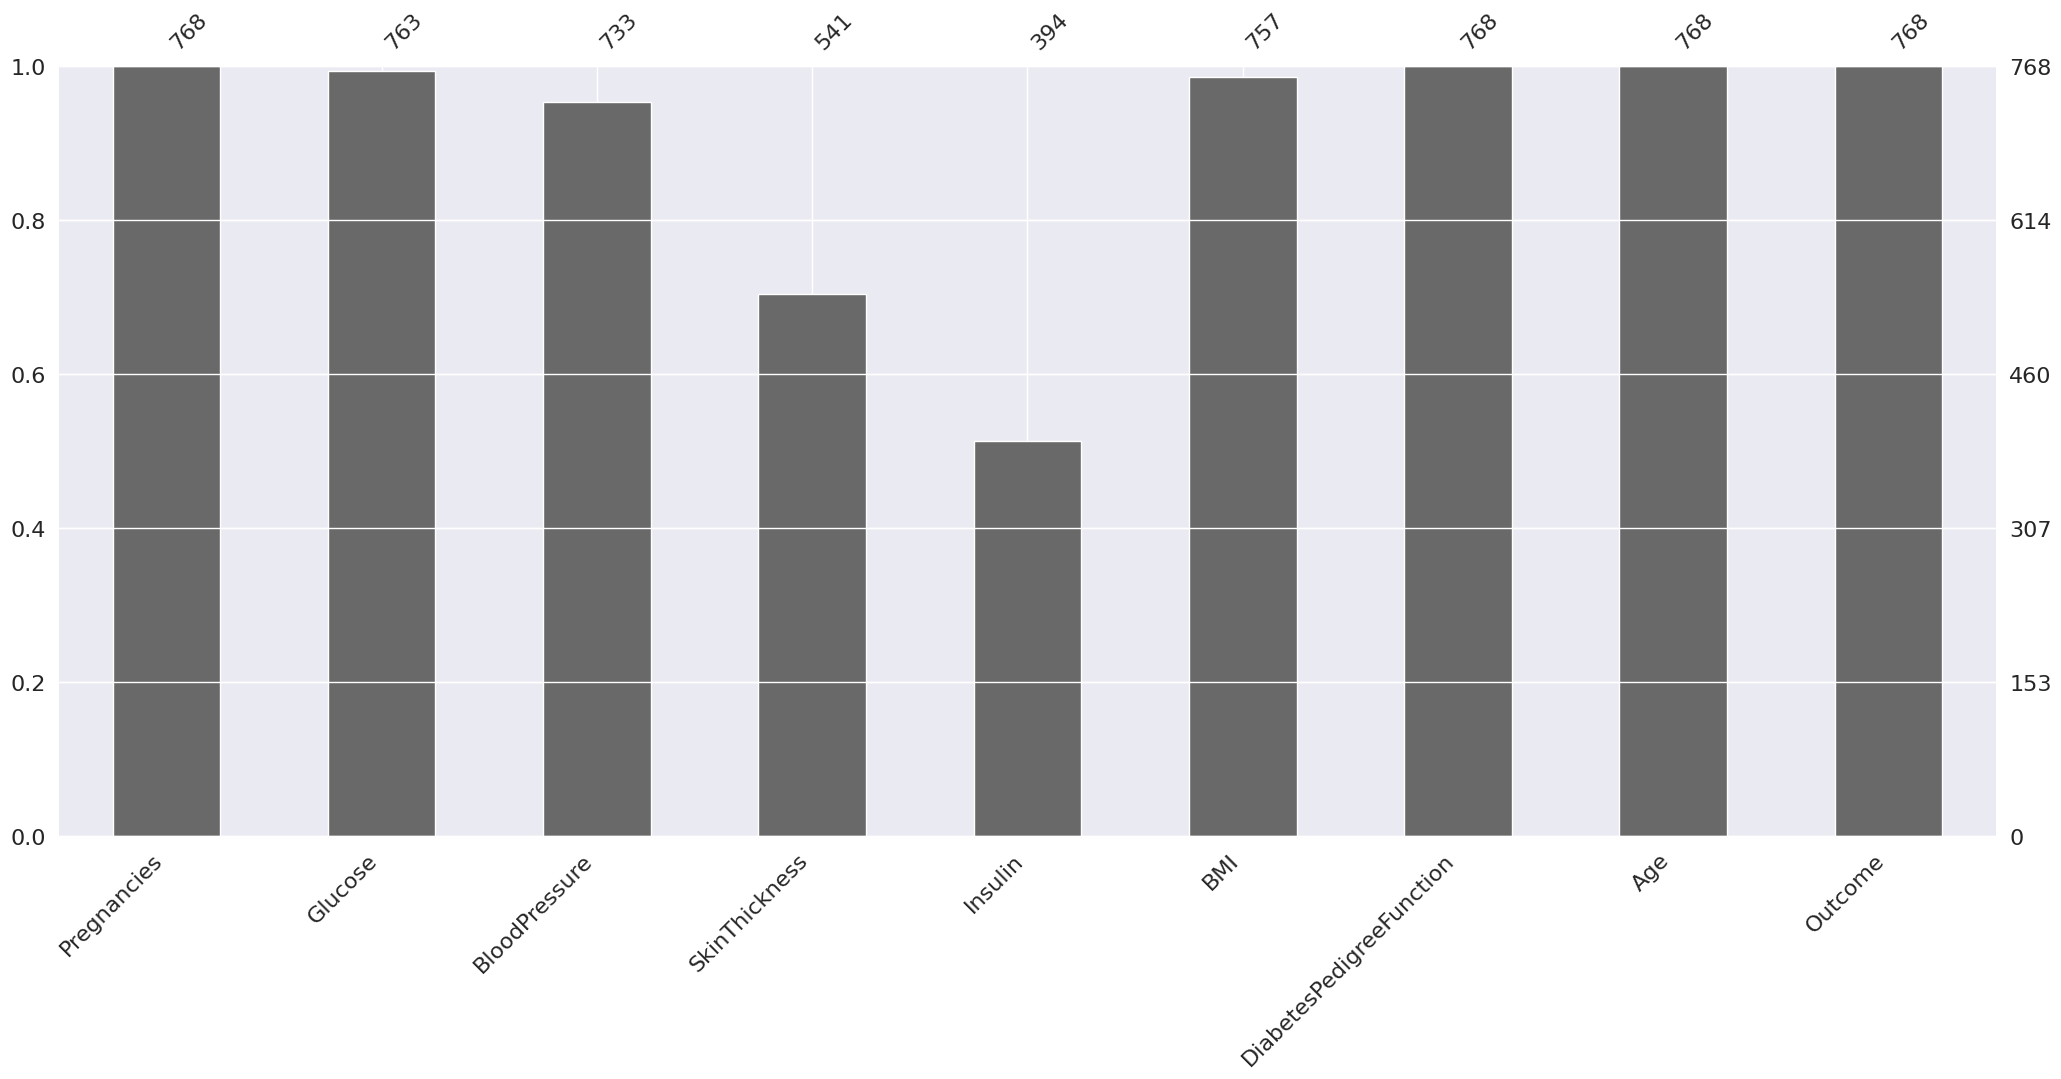

In [12]:
msno.bar(df)

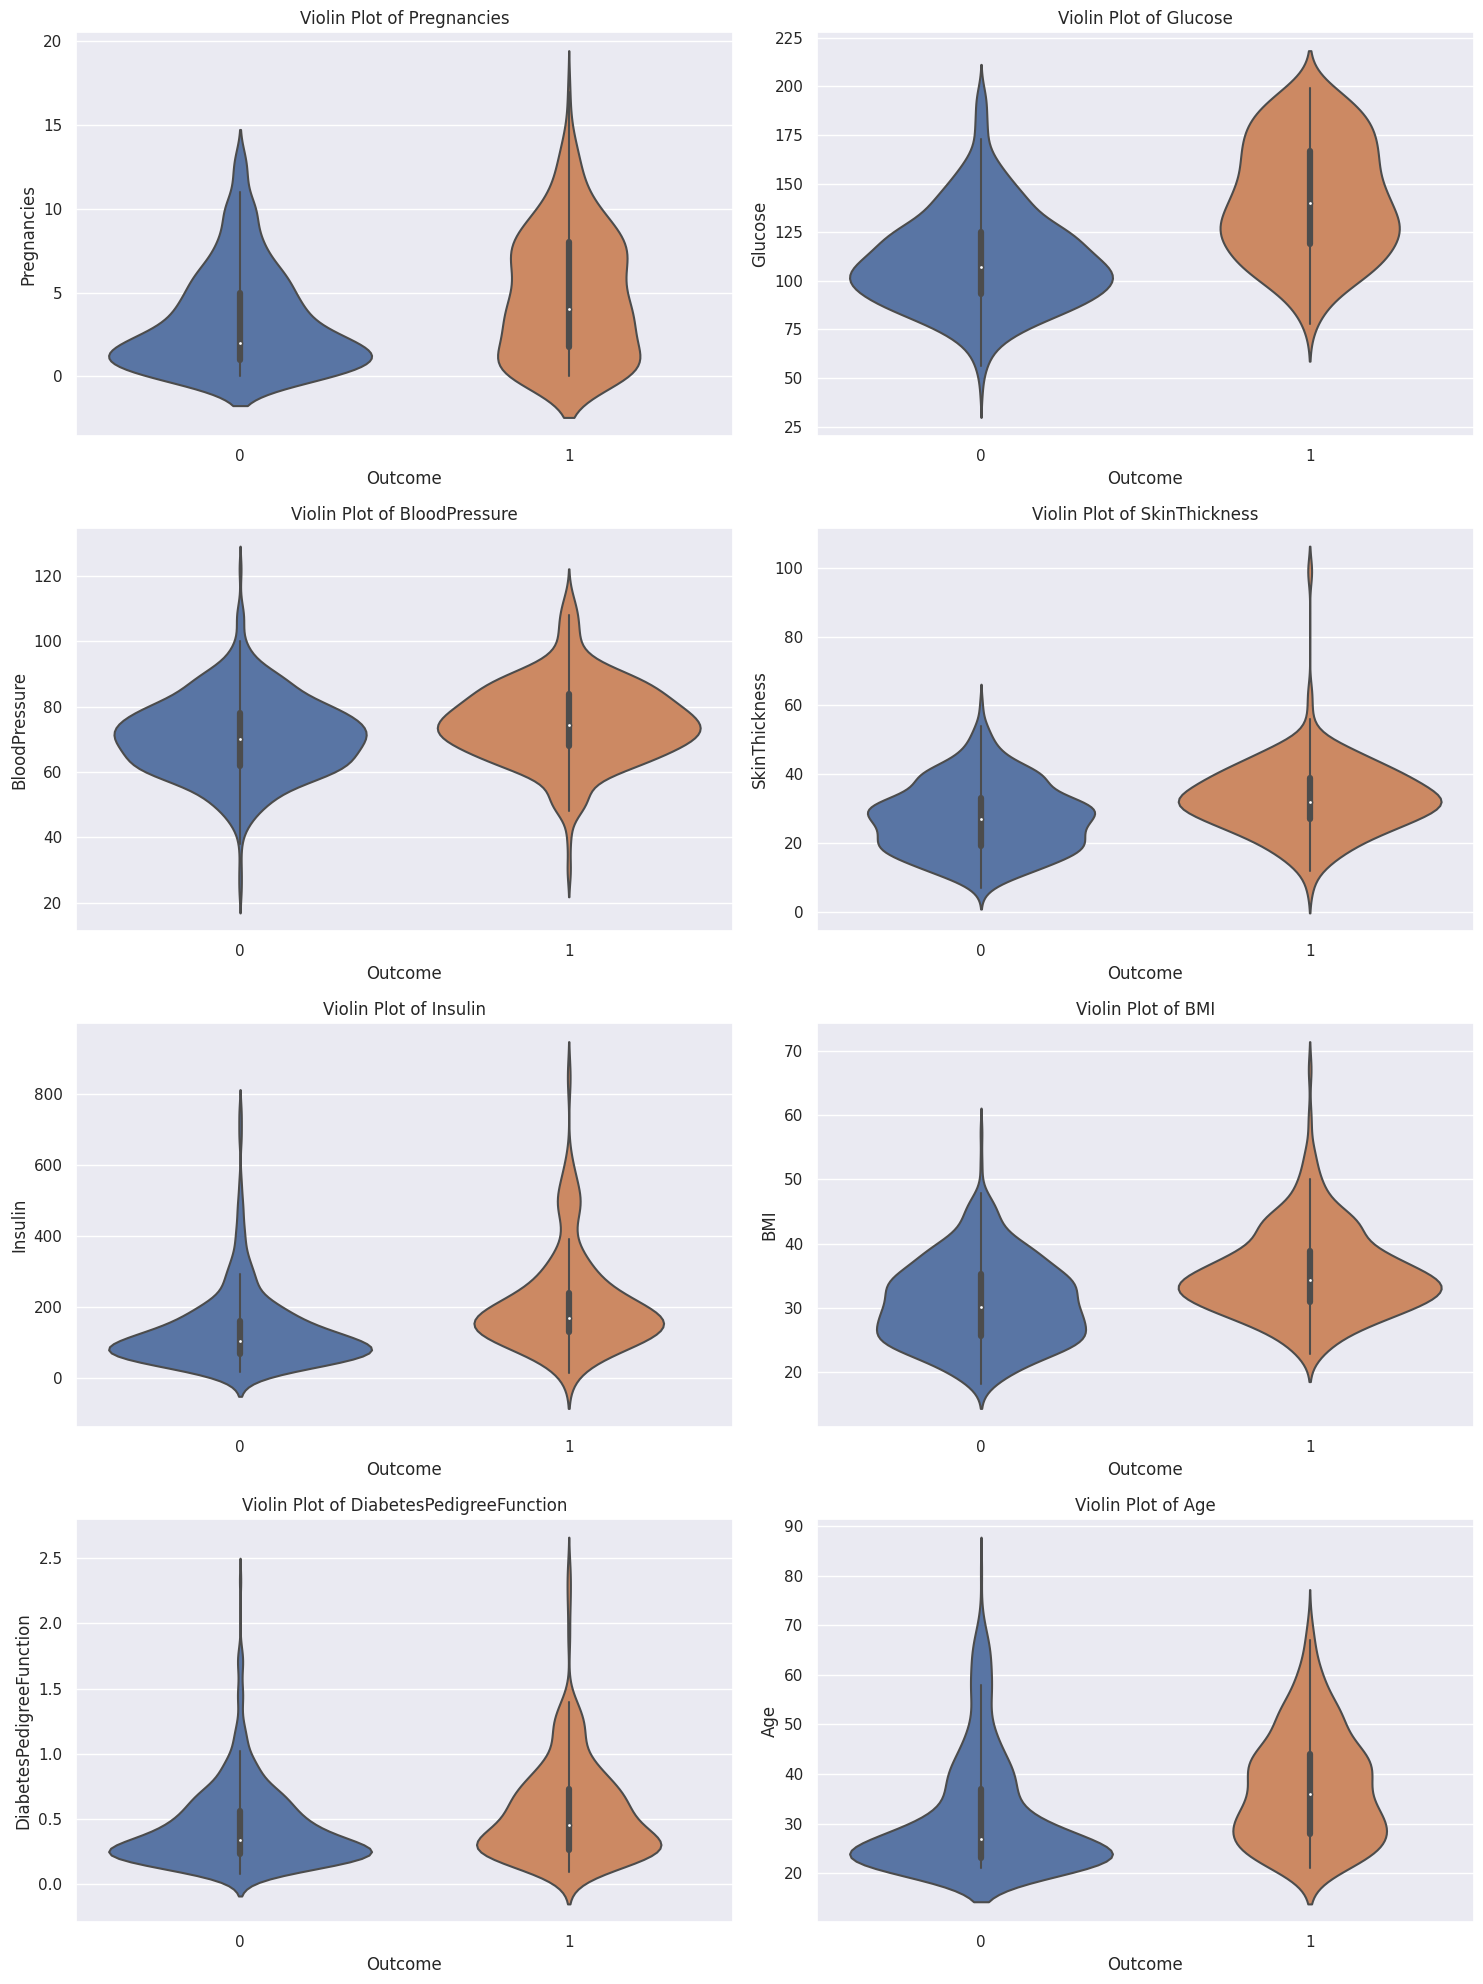

In [13]:
# Specify the columns you want to plot
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age']

# Create subplots
fig, axs = plt.subplots(4, 2, figsize=(15, 20))

# Flatten the axs array for easy iteration
axs = axs.flatten()

# Plot violin plots for each column, split by Outcome
for i, column in enumerate(columns):
    sns.violinplot(x='Outcome', y=column, data=df, ax=axs[i], split=True)
    axs[i].set_title(f'Violin Plot of {column}')

# Adjust layout
plt.tight_layout()
plt.show()


In [14]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,NaN,33.6,0.627,50,1
1,1,85.0,66.0,29.0,NaN,26.6,0.351,31,0
2,8,183.0,64.0,NaN,NaN,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


### Filling the missing values

We have to deal with the missing values. We can delete rows with missing values but it will lead to loss of useful information in our relatively dataset.
So we have to fill values.
There are multiple options to fill like filling by mean, median, mode or random value or some constant.

We looked at the violin plot distribution of the features split by class and there was a clear difference between the distribution in different classes. Like we can see glucose level in people with diabetes is considerably higher. 

So we replace the missing values by median of their class. 

In [15]:
df1=df.groupby(['Outcome']).transform(lambda x: x.fillna(x.median()))
df1['Outcome']=df['Outcome']

In [16]:
df1.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148.0,72.0,35.0,169.5,33.6,0.627,50,1
1,1,85.0,66.0,29.0,102.5,26.6,0.351,31,0
2,8,183.0,64.0,32.0,169.5,23.3,0.672,32,1
3,1,89.0,66.0,23.0,94.0,28.1,0.167,21,0
4,0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [17]:
df1.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

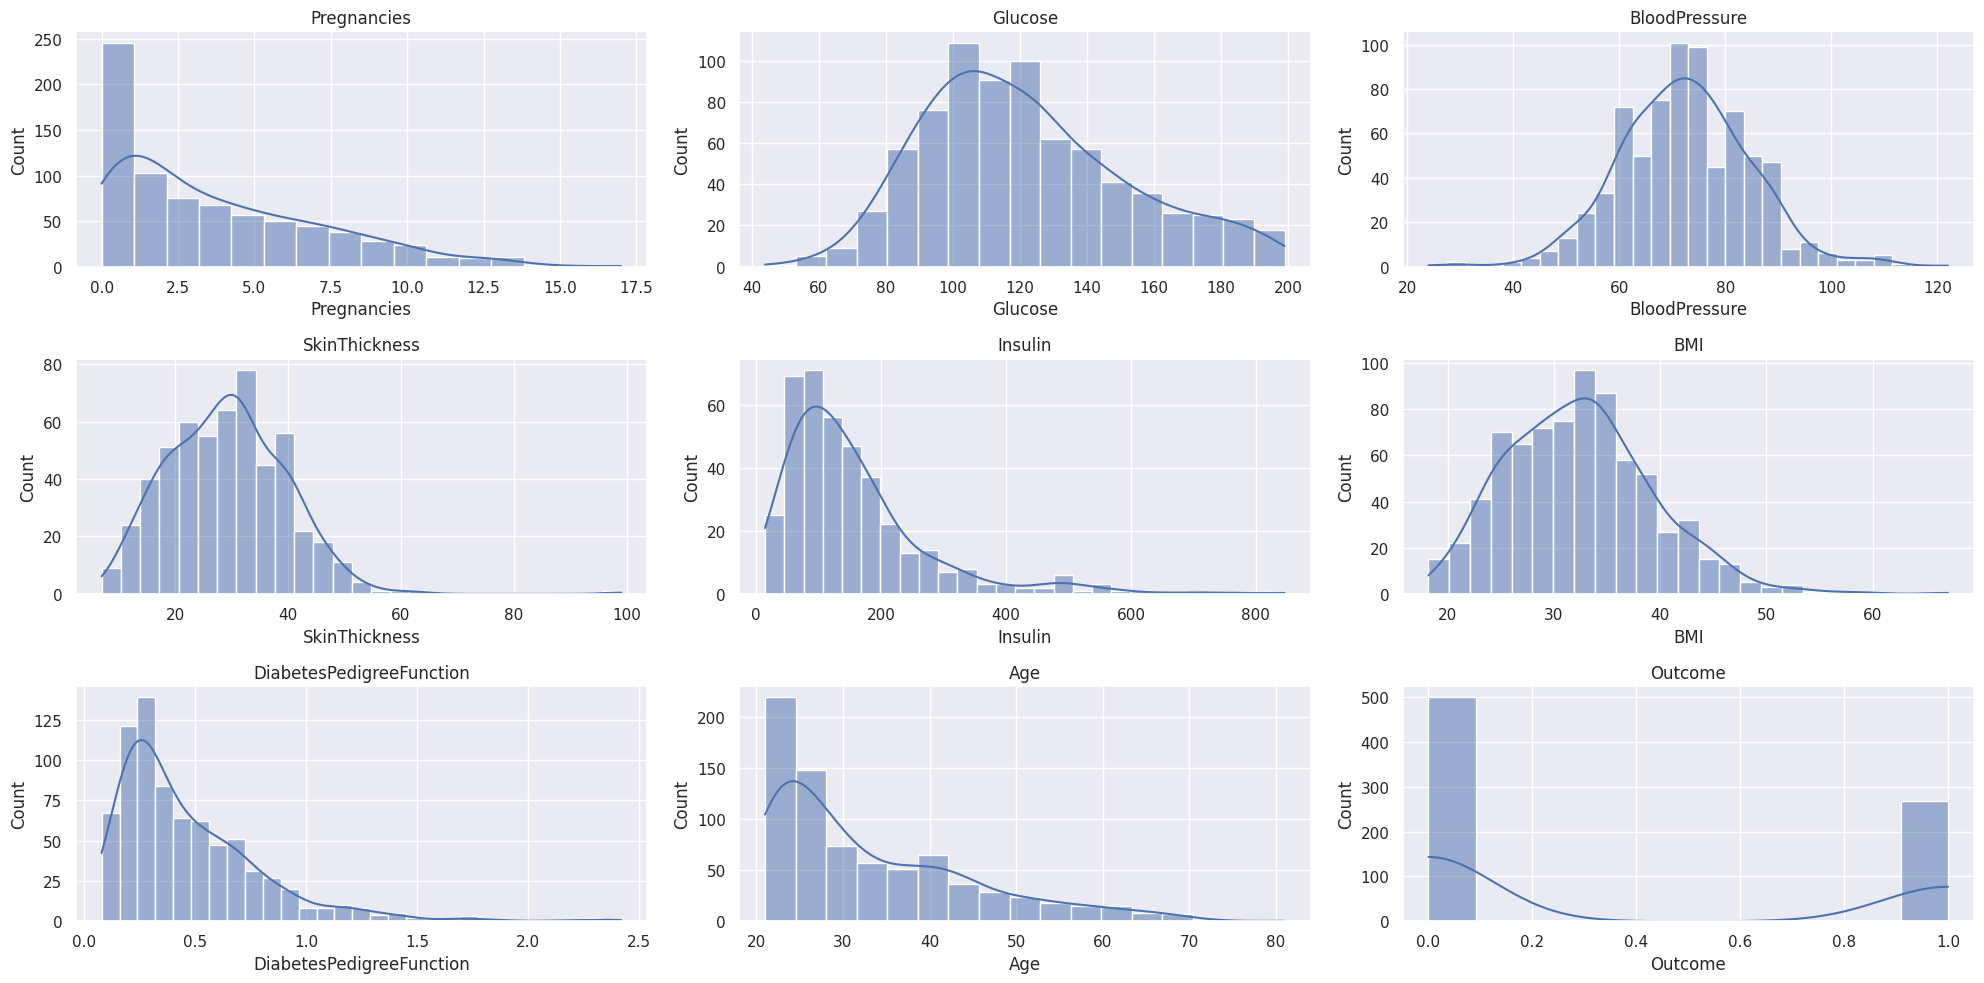

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting histograms for all columns
plt.figure(figsize=(20, 10))
for i, col in enumerate(df1.columns):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True)
    plt.title(col)
plt.tight_layout()
plt.show()


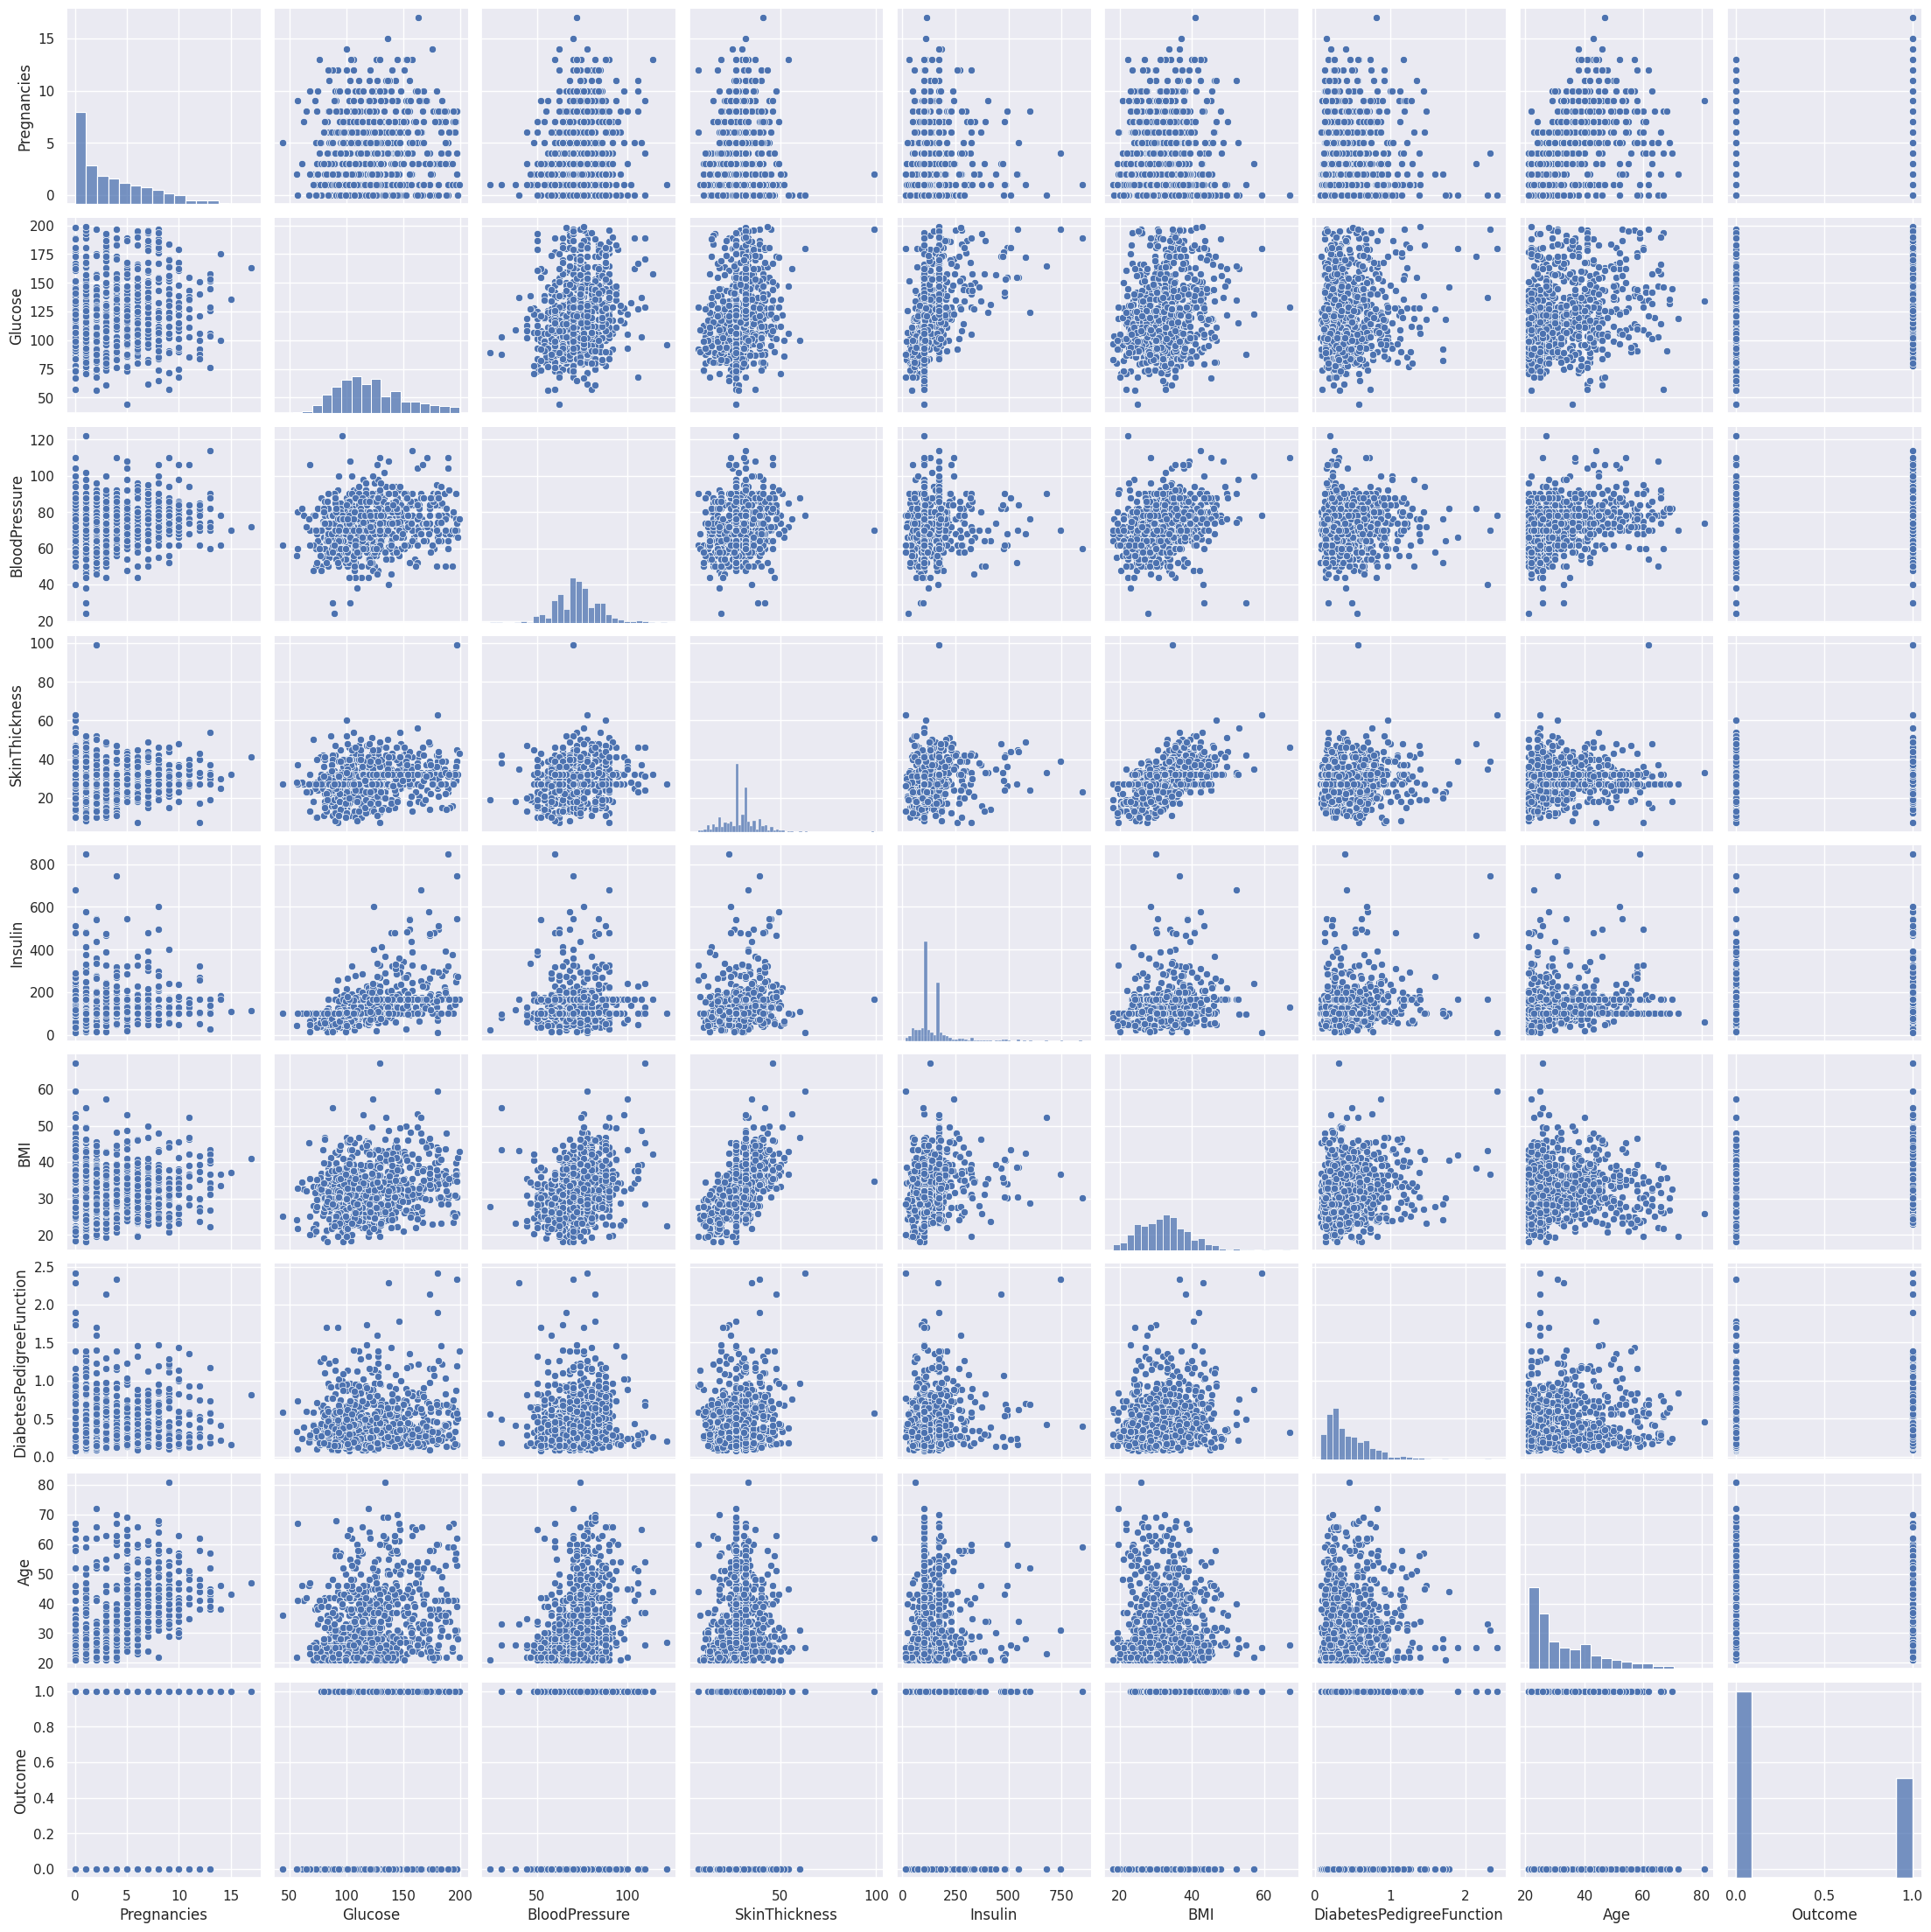

In [19]:
sns.pairplot(df1)
plt.show()


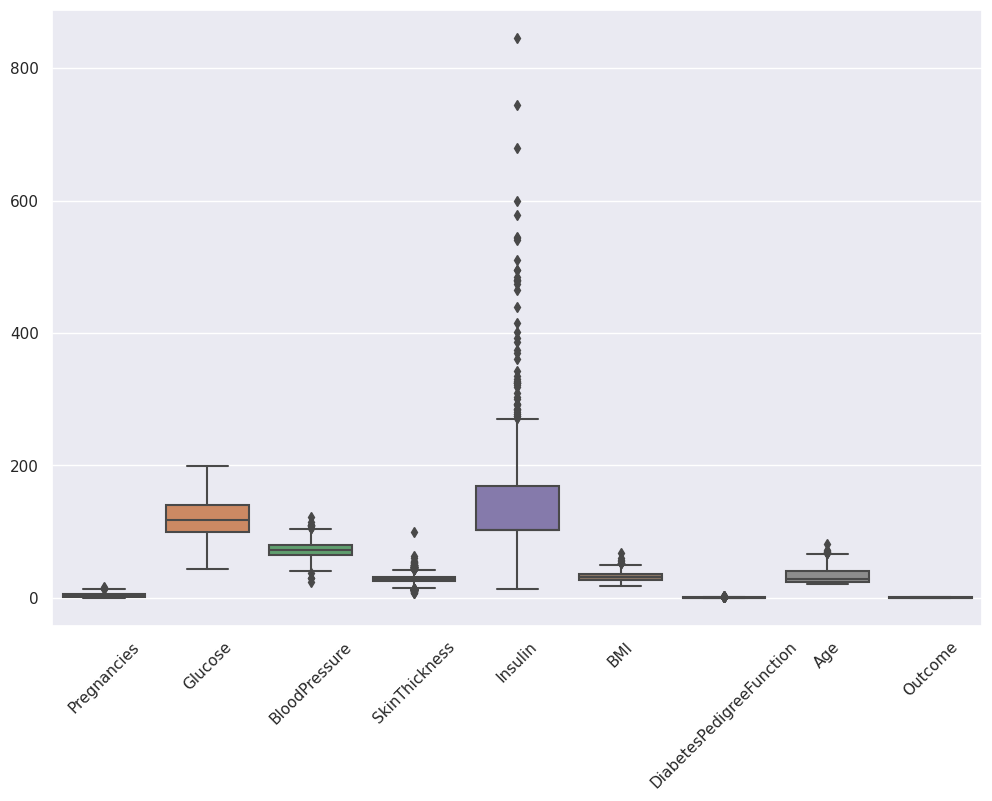

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.figure(figsize=(12, 8))
sns.boxplot(data=df1)
plt.xticks(rotation=45)
plt.show()


In the boxplot we can see the variation between the scale of various features. We have to correct because it can adversibly effect our models. Some features can have disproportionate effect on our model if they are not scaled properly.

### Correlation matrix

<Axes: >

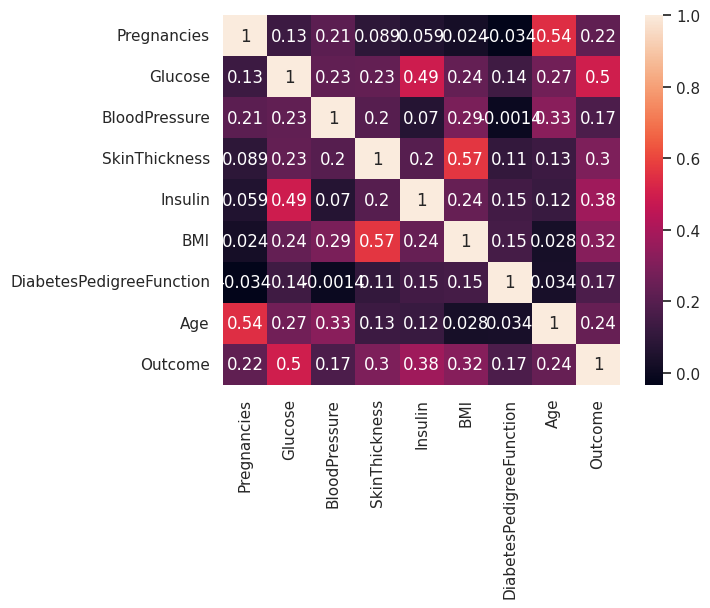

In [21]:
sns.heatmap(df1.corr(),annot=True)


We can see feature Glucose is highly correlated with Outcome. It is going to be important in our model. Similarly Insuling, BMI have high correlation.

### Checking class balance of the target variable

We check the class balance of the target variable 'Outcome' in our dataset and find it is imbalanced. There are nearly double patients with Outcome zero or false. We have to balance our data because Imbalanced classes can lead to biased models that favor the majority class, making it challenging for the model to learn patterns from the minority class.

<Axes: xlabel='Outcome', ylabel='count'>

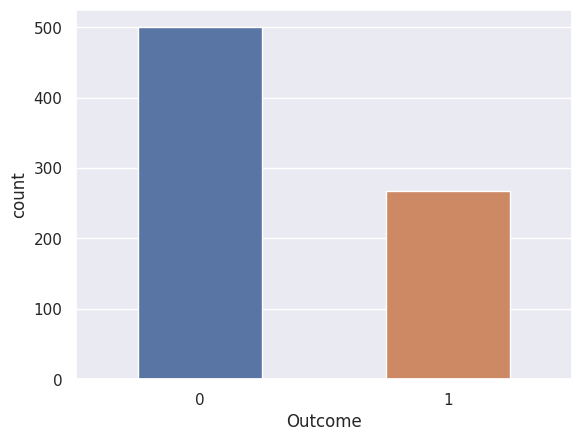

In [22]:
sns.countplot(x='Outcome',data=df1,width=0.5)


### Splitting independent, dependent features

In [23]:
X=df1.drop(['Outcome'],axis=1)
y=df1['Outcome']

In [24]:
X.shape,y.shape

((768, 8), (768,))

### Test train split

In [25]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)


### Scaling

In [26]:
scaler=StandardScaler()
columns=X.columns

In [27]:
X_train=scaler.fit_transform(X_train)
X_train=pd.DataFrame(X_train,columns=columns)

In [28]:
X_test=scaler.transform(X_test)
X_test=pd.DataFrame(X_test,columns=columns)

In [29]:
X_train.shape, X_test.shape

((614, 8), (154, 8))

### Using SMOTE to treat class imbalance
As we saw earlier, the target outcome is highly imbalanced. We use SMOTE technique to create artificial/synthetic data for minority class to balance out the data.

In [30]:
from imblearn.over_sampling import SMOTE


In [31]:
np.bincount(y_train)

array([393, 221])

In [32]:
smt=SMOTE()
X_train,y_train=smt.fit_resample(X_train,y_train)

In [33]:
np.bincount(y_train)

array([393, 393])

### Training models

### Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

# Create and train the logistic regression model
lr_model = LogisticRegression(random_state=0)
lr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred_lr = lr_model.predict(X_test)

# Calculate the F1 score
f1_lr = f1_score(y_test, y_pred_lr)

print(f1_lr)
# Generate the classification report
report_lr = classification_report(y_test, y_pred_lr)

print(report_lr)

0.7307692307692306
              precision    recall  f1-score   support

           0       0.91      0.82      0.86       107
           1       0.67      0.81      0.73        47

    accuracy                           0.82       154
   macro avg       0.79      0.82      0.80       154
weighted avg       0.83      0.82      0.82       154



### KNN

In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# Define the parameter grid
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'leaf_size': [15, 20, 30, 40]
}

# Create the KNN classifier
knn = KNeighborsClassifier()

# Create the GridSearchCV object
grid_search_knn = GridSearchCV(knn, param_grid_knn, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search_knn.fit(X_train, y_train)

# Make predictions on the test data
y_pred_knn = grid_search_knn.predict(X_test)

# Generate the classification report
report_knn = classification_report(y_test, y_pred_knn)

print(report_knn)


Fitting 5 folds for each of 32 candidates, totalling 160 fits
              precision    recall  f1-score   support

           0       0.92      0.79      0.85       107
           1       0.65      0.85      0.73        47

    accuracy                           0.81       154
   macro avg       0.78      0.82      0.79       154
weighted avg       0.84      0.81      0.82       154



### Support Vector Classifier

In [42]:
from sklearn.svm import SVC

# Define the parameter grid
param_grid_svm = {
    'C': [0.1, 1, 10, 100, 1000],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf']
}

# Create the SVM classifier
svm = SVC()

# Create the GridSearchCV object
grid_search_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search_svm.fit(X_train, y_train)

# Make predictions on the test data
y_pred_svm = grid_search_svm.predict(X_test)

# Generate the classification report
report_svm = classification_report(y_test, y_pred_svm)

print(report_svm)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       107
           1       0.68      0.77      0.72        47

    accuracy                           0.82       154
   macro avg       0.79      0.80      0.79       154
weighted avg       0.83      0.82      0.82       154



### Decision Tree

In [38]:
from sklearn.tree import DecisionTreeClassifier


# Define the parameter grid
param_grid_dtree = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 5, 10, 15],  
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 4]
}

# Create the Decision Tree classifier
dtree = DecisionTreeClassifier(random_state=0)

# Create the GridSearchCV object
grid_search_dtree = GridSearchCV(dtree, param_grid_dtree, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search_dtree.fit(X_train, y_train)

# Make predictions on the test data
y_pred_dtree = grid_search_dtree.predict(X_test)

# Generate the classification report
report_dtree = classification_report(y_test, y_pred_dtree)

print(report_dtree)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       107
           1       0.75      0.77      0.76        47

    accuracy                           0.85       154
   macro avg       0.82      0.83      0.82       154
weighted avg       0.85      0.85      0.85       154



### Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid_rf = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the Random Forest classifier
rf = RandomForestClassifier(random_state=0)

# Create the GridSearchCV object
grid_search_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred_rf = grid_search_rf.predict(X_test)

# Generate the classification report
report_rf = classification_report(y_test, y_pred_rf)

print(report_rf)


Fitting 5 folds for each of 144 candidates, totalling 720 fits
              precision    recall  f1-score   support

           0       0.94      0.89      0.91       107
           1       0.77      0.87      0.82        47

    accuracy                           0.88       154
   macro avg       0.86      0.88      0.87       154
weighted avg       0.89      0.88      0.88       154



### XGB Classifier

In [39]:
from xgboost import XGBClassifier

# Define the parameter grid
param_grid_xgb = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [2, 3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3, 0.5]
}

# Create the XGBoost classifier
xgb = XGBClassifier(random_state=0)

# Create the GridSearchCV object
grid_search_xgb = GridSearchCV(xgb, param_grid_xgb, cv=5, n_jobs=-1, verbose=1, scoring='f1')

# Fit the GridSearchCV object to the training data
grid_search_xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred_xgb = grid_search_xgb.predict(X_test)

# Generate the classification report
report_xgb = classification_report(y_test, y_pred_xgb)

print(report_xgb)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
              precision    recall  f1-score   support

           0       0.96      0.89      0.92       107
           1       0.78      0.91      0.84        47

    accuracy                           0.90       154
   macro avg       0.87      0.90      0.88       154
weighted avg       0.91      0.90      0.90       154



### Comparing performance of all models

In [43]:
from sklearn.metrics import f1_score

# Initialize a dictionary to store F1 scores for each model
f1_scores = {}

# Calculate F1 score for Logistic Regression
f1_lr = f1_score(y_test, y_pred_lr)
f1_scores['Logistic Regression'] = f1_lr

# Calculate F1 score for KNN
f1_knn = f1_score(y_test, y_pred_knn)
f1_scores['KNN'] = f1_knn

# Calculate F1 score for SVM
f1_svm = f1_score(y_test, y_pred_svm)
f1_scores['SVM'] = f1_svm

# Calculate F1 score for Decision Tree
f1_dtree = f1_score(y_test, y_pred_dtree)
f1_scores['Decision Tree'] = f1_dtree

# Calculate F1 score for Random Forest
f1_rf = f1_score(y_test, y_pred_rf)
f1_scores['Random Forest'] = f1_rf

# Calculate F1 score for XGBoost
f1_xgb = f1_score(y_test, y_pred_xgb)
f1_scores['XGBoost'] = f1_xgb

# Display the F1 scores for each model
for model, f1 in f1_scores.items():
    print(f"F1 Score for {model}: {f1}")


F1 Score for Logistic Regression: 0.7307692307692306
F1 Score for KNN: 0.7339449541284404
F1 Score for SVM: 0.72
F1 Score for Decision Tree: 0.7578947368421053
F1 Score for Random Forest: 0.8200000000000001
F1 Score for XGBoost: 0.8431372549019609


### Stacking top two performing models
Stacking allows us to combine the strengths of multiple models, potentially improving overall performance. 

In [44]:
from sklearn.ensemble import StackingClassifier


# Best models obtained from GridSearchCV
best_xgb = grid_search_xgb.best_estimator_
best_rf = grid_search_rf.best_estimator_

# Stacking classifier with just XGBoost and Random Forest
stacked_classifier = StackingClassifier(
    estimators=[
        ('xgb', best_xgb),
        ('rf', best_rf)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)

# Training the stacked classifier
stacked_classifier.fit(X_train, y_train)

# Predicting with the stacked classifier
y_pred_stacked = stacked_classifier.predict(X_test)

# Evaluating the stacked classifier
print(classification_report(y_test, y_pred_stacked))


              precision    recall  f1-score   support

           0       0.95      0.90      0.92       107
           1       0.79      0.89      0.84        47

    accuracy                           0.90       154
   macro avg       0.87      0.90      0.88       154
weighted avg       0.90      0.90      0.90       154



In [45]:
f1_stacked = f1_score(y_test, y_pred_stacked)

In [46]:
f1_stacked

0.8400000000000001

### Collating performance of all models including stacked model

In [47]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


models = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost', 'Stacked']

results = []

for i, y_pred in enumerate([y_pred_lr, y_pred_knn, y_pred_svm, y_pred_dtree, y_pred_rf, y_pred_xgb, y_pred_stacked]):
    if i < 6:
        model_name = models[i]
    else:
        model_name = models[i] + ' (XGB + RF)'
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    results.append({'Model': model_name, 'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1})

results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.818182   0.666667  0.808511  0.730769
1                  KNN  0.811688   0.645161  0.851064  0.733945
2                  SVM  0.818182   0.679245  0.765957  0.720000
3        Decision Tree  0.850649   0.750000  0.765957  0.757895
4        Random Forest  0.883117   0.773585  0.872340  0.820000
5              XGBoost  0.896104   0.781818  0.914894  0.843137
6   Stacked (XGB + RF)  0.896104   0.792453  0.893617  0.840000
